In [2]:
import pandas as pd

# Read the CSV file into a DataFrame
column_names = ["text", "is_hate"]

df = pd.read_csv('1.preprocessed_data.csv', on_bad_lines='skip', sep=",", encoding='iso-8859-1', header=0, names=column_names)
df['is_hate'] = df['is_hate'].astype(bool)
df['text'] = df['text'].astype('str')
df.head()

,text,is_hate
0,ponnayo danne kellek aduwa gaman laga inna kol...,True
1,ape harak samjeta eka honda adrshyak,False
2,tpita pisuda yako man htuwe atta kiyala aiyo,False
3,kimbak eduwoth ape untath amma thaththawath pe...,True
4,lisan nathawa yanna puluwan yako api dannawa o...,False


In [6]:
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

# Load your dataframe
# df = pd.read_csv("your_dataset.csv")

# Split data and reset index
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Tokenizer setup
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
tokenizer.pad_token = tokenizer.eos_token

# Dataset preparation
class HateSpeechDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.is_hate
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index].text)

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=False,
            return_token_type_ids=True,
            truncation=True,
            padding='max_length'
        )
        return {
            "input_ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.data.iloc[index].is_hate, dtype=torch.long)
        }

MAX_LEN = 256
train_dataset = HateSpeechDataset(train_df, tokenizer, MAX_LEN)
val_dataset = HateSpeechDataset(val_df, tokenizer, MAX_LEN)

# Model and Training setup
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=500,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    save_strategy="epoch",
)

model = GPT2ForSequenceClassification.from_pretrained("gpt2-medium", num_labels=2)
model.config.pad_token_id = model.config.eos_token_id
model.resize_token_embeddings(len(tokenizer))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

# Evaluation and Prediction
results = trainer.evaluate()
predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(-1)

# Prediction function
def predict_hate_speech(text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        pad_to_max_length=False,
        return_token_type_ids=True,
        truncation=True,
        padding='max_length',
        return_tensors="pt"
    )
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = logits.softmax(dim=1)
    return "Hate" if probs[0, 1] > 0.5 else "Not Hate"

# Example
text = "Your example text here"
print(predict_hate_speech(text))


KeyboardInterrupt: 

In [3]:
from sklearn.metrics import classification_report
true_labels = val_dataset.targets.tolist()
predicted_labels = predictions.predictions.argmax(-1).tolist()

report = classification_report(true_labels, predicted_labels, target_names=['Not Hate', 'Hate'])
print(report)


              precision    recall  f1-score   support

    Not Hate       0.80      0.87      0.84       132
        Hate       0.78      0.69      0.73        89

    accuracy                           0.80       221
   macro avg       0.79      0.78      0.78       221
weighted avg       0.80      0.80      0.79       221



In [4]:
# Save the model
model.save_pretrained("2.14 gpt_model")

# Save the tokenizer
tokenizer.save_pretrained("2.14 gpt_tokenizer")

Configuration saved in 2.14 gpt_model/config.json
Model weights saved in 2.14 gpt_model/pytorch_model.bin
tokenizer config file saved in 2.14 gpt_tokenizer/tokenizer_config.json
Special tokens file saved in 2.14 gpt_tokenizer/special_tokens_map.json


('2.14 gpt_tokenizer/tokenizer_config.json',
 '2.14 gpt_tokenizer/special_tokens_map.json',
 '2.14 gpt_tokenizer/vocab.json',
 '2.14 gpt_tokenizer/merges.txt',
 '2.14 gpt_tokenizer/added_tokens.json')

In [5]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Load the model
loaded_model = GPT2ForSequenceClassification.from_pretrained("2.14 gpt_model")

# Load the tokenizer
loaded_tokenizer = GPT2Tokenizer.from_pretrained("2.14 gpt_tokenizer")
                                                 
# Prediction function
def predict_hate_speech_from_saved(text, model, tokenizer):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
        truncation=True,
        padding='max_length',
        return_tensors="pt"
    )
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = logits.softmax(dim=1)
    return "Hate" if probs[0, 1] > 0.5 else "Not Hate"

# Example
text = "Your example text here"
print(predict_hate_speech_from_saved(text, loaded_model, loaded_tokenizer))


loading configuration file 2.14 gpt_model/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2-medium",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "n_special": 0,
  "pad_token_id": 50256,
  "predict_special_tokens": true,
  "problem_type": "single_label_classification",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max

Not Hate


In [6]:
print(predict_hate_speech_from_saved("kalakanni deshapaluwo", loaded_model, loaded_tokenizer))

Hate


In [7]:
print(predict_hate_speech("kalakanni deshapaluwo"))

Hate


[[115  17]
 [ 28  61]]


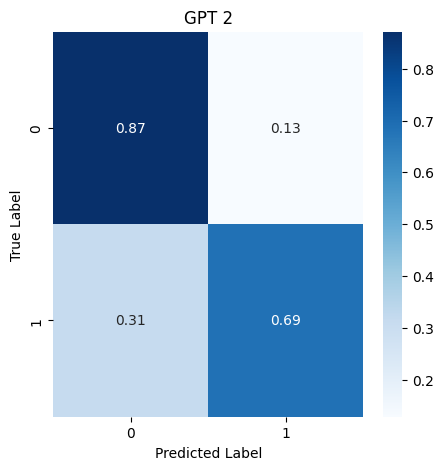

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# After making predictions
true_labels = val_dataset.targets.tolist()
predicted_labels = predictions.predictions.argmax(-1).tolist()

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Normalize the confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues')
plt.title('GPT 2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


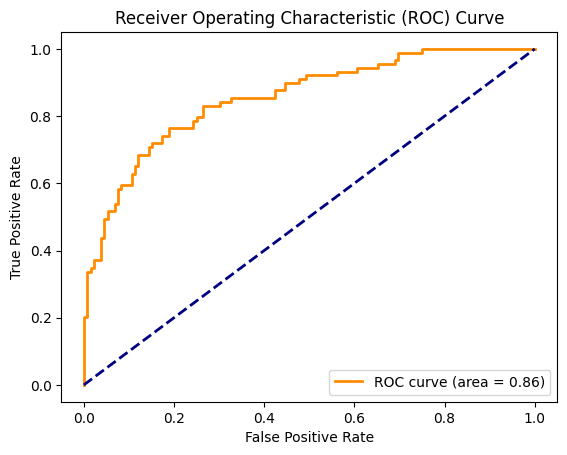

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [12]:
import pickle

# save the values to a file
print(report)
report = classification_report(true_labels, predicted_labels, target_names=['True', 'False'])
with open('2.14 GPT2.pkl', 'wb') as f:
    pickle.dump({
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'cm_percentage': cm_percentage, 'report': report
    }, f)


              precision    recall  f1-score   support

    Not Hate       0.80      0.87      0.84       132
        Hate       0.78      0.69      0.73        89

    accuracy                           0.80       221
   macro avg       0.79      0.78      0.78       221
weighted avg       0.80      0.80      0.79       221

